<a href="https://colab.research.google.com/github/archana070723/Womanium_project/blob/main/Quantum_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pennylane qiskit qiskit-aer --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.3 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.stats import norm, expon, entropy
import numpy as np
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt

# Quantum peg logic
def quantum_peg(qc, control, mid):

    left = mid - 1
    right = mid + 1
    print("Quantum peg on qubits:",left,mid,right)
    # print()
    if left != control and mid != control:
        qc.cswap(control, left, mid)
    qc.cx(mid, control)
    if mid != control and right != control:
        qc.cswap(control, mid, right)

# General QGB circuit builder
def generate_qgb_qiskit(n_qubits, n_levels, shots=8192):
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits )
    qc = QuantumCircuit(qr, cr)
    mid = n_qubits // 2
    qc.x(qr[mid])  # Ball starts in center
    qc.h(qr[0])  # Ball starts in center

    # for i in range(n_levels):
    #     print("For level=",i)
    #     control = 0
    #     if i == 0:
    #         # quantum_peg(qc, control, mid)
    #     else:
    #         qc.reset(qr[control])
    #         qc.h(qr[control])

    for j in range(n_levels):
      mid2=mid
      print("For level=",j)
      control = 0
      if j == 0:
             quantum_peg(qc, control, mid)
      else:
          qc.reset(qr[control])
          qc.h(qr[control])
          mid2=mid2-j
          for i in range(j+1):
            rightmost=mid2+1
            if( mid2-1 !=0 and mid2 + 1 !=n_qubits ):
              print("mid2=",mid2)
              quantum_peg(qc, control, mid2 )
              if (i!=j):
                qc.cx(qr[rightmost], qr[control])
              mid2=mid2+2
              print("Updated mid2=",mid2)
              # quantum_peg(qc, control, mid + (j))
    qc.barrier()
    for i in range(1, n_qubits ):
        qc.measure(qr[i], cr[i])
    print(qc.draw())
    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    print (counts)
    plt.figure(figsize=(10, 5))
    # Plot raw measurement histogram before postprocessing
    plot_histogram(counts, title="Raw QGB Measurement Counts")
    plt.show()
    return counts

# Post-processing
def process_results(counts, dist_type="gaussian"):
    keys = list(counts.keys())
    values = [int(k, 2) for k in keys]
    total = sum(counts.values())
    normalized_sim = {int(k, 2): v / total for k, v in counts.items()}
    x = np.arange(min(values), max(values)+1)

    if dist_type == "gaussian":
        mu, sigma = 16, np.sqrt(5)
        ideal = norm.pdf(x, mu, sigma)
    elif dist_type == "exponential":
        ideal = expon.pdf(x, scale=4)
    else:
        ideal = np.ones_like(x) / len(x)

    ideal = ideal #/ np.sum(ideal)
    sim = np.array([normalized_sim.get(i, 0) for i in x])
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))

    plt.figure(figsize=(10, 5))
    plt.bar(x, sim, label="QGB Simulated", alpha=0.6)
    plt.plot(x, ideal, label=f"Ideal {dist_type.title()} Distribution", color="r", linestyle="--")
    plt.xlabel("Output value")
    plt.ylabel("Probability")
    plt.title(f"QGB Simulation vs. Ideal {dist_type.title()} Distribution")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return kl, tvd, normalized_sim
# Post-processing with 4-bit rescaling and block summing
def process_and_plot_blocked(counts, dist_type="gaussian"):
    shots = sum(counts.values())
    strings = []
    for bitstring, count in counts.items():
        strings.extend([bitstring] * count)

    remapped = []
    for s in strings:
        index = s[::-1].find('1')
        remapped.append(index if index != -1 else 4)  # Map to 0–4

    blocks = [sum(remapped[i:i+8]) for i in range(0, len(remapped), 8) if len(remapped[i:i+8]) == 8]
    x = sorted(set(blocks))
    hist = {i: blocks.count(i) for i in x}
    total = sum(hist.values())
    normalized_sim = {k: v / total for k, v in hist.items()}

    x_vals = np.arange(min(x), max(x) + 1)
    sim = np.array([normalized_sim.get(i, 0) for i in x_vals])

    if dist_type == "gaussian":
        mu, sigma = 16, np.sqrt(5)
        ideal = norm.pdf(x_vals, mu, sigma)
    elif dist_type == "exponential":
        ideal = expon.pdf(x_vals, scale=4)
    else:
        ideal = np.ones_like(x_vals) / len(x_vals)

    ideal = ideal #/ np.sum(ideal)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))

    plt.figure(figsize=(10, 5))
    plt.bar(x_vals, sim, label="QGB Simulated", alpha=0.6)
    plt.plot(x_vals, ideal, label=f"Ideal {dist_type.title()} Distribution", color="r", linestyle="--")
    plt.xlabel("Sum of 8 Block Values")
    plt.ylabel("Probability")
    plt.title(f"Postprocessed QGB Output vs. Ideal {dist_type.title()} Distribution")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return kl, tvd, normalized_sim

# Run for 2 layers
layers = 4
n_qubits = 2 * layers + 2
counts = generate_qgb_qiskit(n_qubits, layers)
print(counts)
# kl_gauss, tvd_gauss, _ = process_and_plot_blocked(counts, dist_type="gaussian")

# counts_exp = generate_qgb_qiskit(n_qubits, layers)
# kl_exp, tvd_exp, _ = process_and_plot_blocked(counts_exp, dist_type="exponential")


For level= 0
Quantum peg on qubits: 4 5 6
For level= 1
mid2= 4
Quantum peg on qubits: 3 4 5
Updated mid2= 6
mid2= 6
Quantum peg on qubits: 5 6 7
Updated mid2= 8
For level= 2
mid2= 3
Quantum peg on qubits: 2 3 4
Updated mid2= 5
mid2= 5
Quantum peg on qubits: 4 5 6
Updated mid2= 7
mid2= 7
Quantum peg on qubits: 6 7 8
Updated mid2= 9
For level= 3
mid2= 2
Quantum peg on qubits: 1 2 3
Updated mid2= 4
mid2= 4
Quantum peg on qubits: 3 4 5
Updated mid2= 6
mid2= 6
Quantum peg on qubits: 5 6 7
Updated mid2= 8
mid2= 8
Quantum peg on qubits: 7 8 9
Updated mid2= 10
       ┌───┐   ┌───┐        ┌───┐   ┌───┐   ┌───┐   ┌───┐        ┌───┐   ┌───┐»
 q0_0: ┤ H ├─■─┤ X ├─■──|0>─┤ H ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■──|0>─┤ H ├─■─┤ X ├»
       └───┘ │ └─┬─┘ │      └───┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │      └───┘ │ └─┬─┘»
 q0_1: ──────┼───┼───┼────────────┼───┼───┼───┼───┼───┼───┼────────────┼───┼──»
             │   │   │            │   │   │   │   │   │   │            │   │  »
 q0_2: ──────┼───┼───┼────────────┼───┼──

<Figure size 1000x500 with 0 Axes>

{'0000000010': 524, '0000001000': 2084, '0010000000': 1986, '0000100000': 3119, '1000000000': 479}


['0000000010', '0000001000', '0000100000', '0010000000', '1000000000']


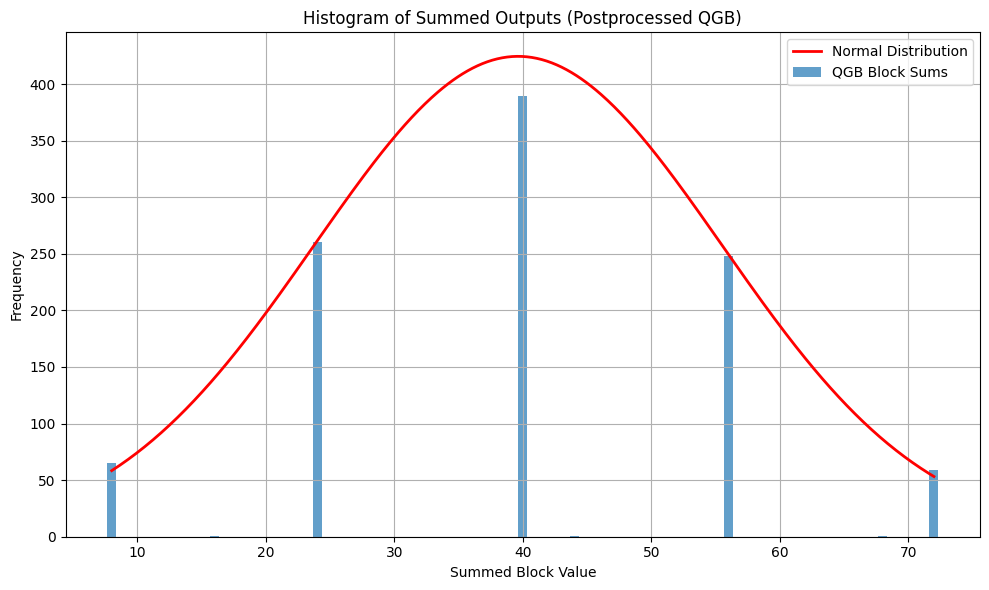

KL Divergence: 6.030598206668911
TVD: 0.680690947590608


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Generic function to map 1-hot bitstring to integer index
def one_hot_to_int(bitstring):
    # Qiskit gives bitstrings in little-endian, so reverse it
    bitstring = bitstring[::-1]
    if bitstring.count('1') != 1:
        return None  # Not a valid 1-hot bitstring
    return bitstring.index('1')

# Step 1: Expand counts into a flat sample list
def expand_onehot_counts(counts):
    samples = []
    for bitstring, freq in counts.items():
        val = one_hot_to_int(bitstring)
        if val is not None:
            samples.extend([val] * freq)
    return samples

# Step 2: Postprocessing block sum
def block_sum_postprocessing(samples, block_size=8):
    num_blocks = len(samples) // block_size
    block_sums = [
        sum(samples[i*block_size:(i+1)*block_size])
        for i in range(num_blocks)
    ]
    return block_sums

# Step 3: Plotting
def plot_histogram_and_gaussian(block_sums):
    hist = Counter(block_sums)
    sorted_keys = sorted(hist.keys())
    frequencies = [hist[k] for k in sorted_keys]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_keys, frequencies, width=0.7, alpha=0.7, label='QGB Block Sums')
    plt.xlabel("Summed Block Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Summed Outputs (Postprocessed QGB)")
    plt.grid(True)

    # Overlay Gaussian
    mean = np.mean(block_sums)
    std = np.std(block_sums)
    mean, scale = np.mean(block_sums), np.std(block_sums)
    x = np.linspace(min(sorted_keys), max(sorted_keys), 500)
    gaussian = len(block_sums) * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
    plt.plot(x, 16.5*gaussian, color='red', linewidth=2, label='Normal Distribution')

    plt.legend()
    plt.tight_layout()
    plt.show()
    sim = np.array([hist.get(i, 0) for i in x]) / sum(sorted_keys)
    ideal = expon.pdf(x, scale=scale)
    ideal /= np.sum(ideal)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))
    return kl, tvd

# Example usage:
# counts = {'0010000000': 130, '0001000000': 246, '1000000000': 135, '0000100000': 513, ...}
samples = expand_onehot_counts(counts)
print(sorted(counts.keys()))
block_sums = block_sum_postprocessing(samples, block_size=8)
kl,tvd=plot_histogram_and_gaussian(block_sums)
print("KL Divergence:", kl)
print("TVD:", tvd)


{'1000000100': 1, '0101000010': 1, '0100100000': 3, '0000001110': 2, '0001110000': 1, '1000001010': 3, '0000110010': 1, '0111000000': 1, '0000110100': 1, '0100000100': 4, '1001000000': 2, '0100010010': 1, '0011000000': 1, '0100001000': 2, '0000010110': 2, '0001000100': 5, '0000000110': 67, '0000110000': 2, '1000000000': 28, '0001000010': 11, '0010100000': 1, '0010000010': 12, '0010001010': 1, '0100000000': 50, '0001010000': 1, '0000010100': 7, '0000010000': 137, '0000000100': 379, '0001000000': 88, '0010000110': 1, '0000000010': 948, '0010010000': 1, '0000000000': 5891, '0000100010': 8, '0010010010': 1, '0000001000': 239, '0000001100': 22, '0000100000': 109, '0010000100': 3, '0000101110': 1, '1000000010': 2, '0000001010': 37, '0100000010': 5, '0010000000': 43, '0000101000': 4, '0000100100': 6, '0000011010': 3, '0100000110': 1, '1000010000': 3, '0001001000': 6, '0100010000': 1, '1000100000': 1, '0000011000': 5, '0000010010': 35, '0001001010': 1}


<Figure size 1000x500 with 0 Axes>

X=, [8, 10, 11, 12, 13, 16, 20, 21, 24, 25, 26, 27, 29, 31, 32, 35, 36, 40, 43, 46, 48, 56, 57, 64, 72]


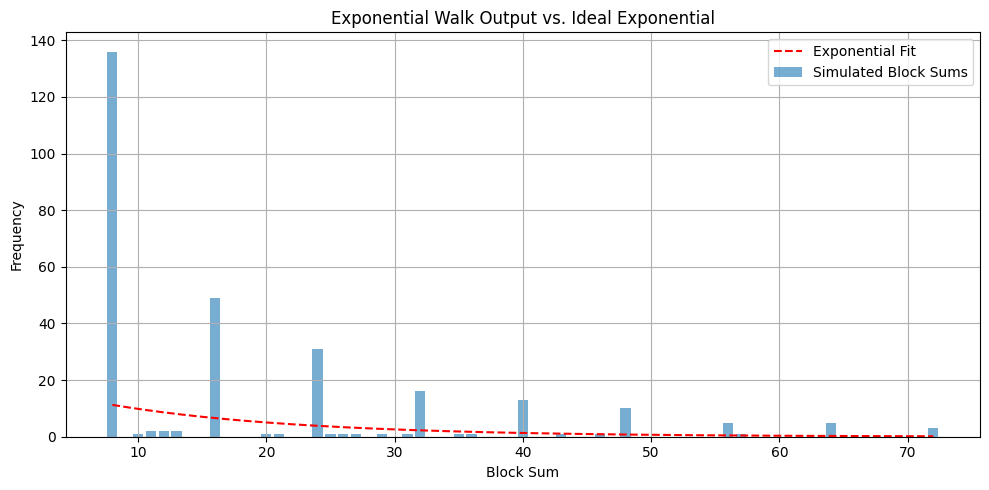

KL Divergence: 1.1108753887485556
TVD: 0.6307370242928506


In [ ]:
# def biased_quantum_peg(qc, control, mid):
#     left = mid - 1
#     right = mid + 1
#     if left != control and mid != control:
#         qc.cswap(control, left, mid)  # Allow left funneling
#     qc.cx(mid, control)  # Entangle
#     # Skip right cswap to bias amplitude toward left

def generate_exponential_walk(n_qubits, n_levels, shots=8192):
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(qr, cr)
    mid = n_qubits // 2
    control = 0
    qc.h(qr[0])    # Control superposition
    for i in range(n_qubits):
        angle = np.pi / (2 * (i + 1))  # larger angle for lower indices
        qc.ry(angle, qr[i])
    # qc.x(qr[mid])  # Start from center
    # qc.h(qr[0])    # Control superposition

    # for level in range(n_levels):
    #     control = 0
    #     if level == 0:
    #         biased_quantum_peg(qc, control, mid)
    #     else:
    #         qc.reset(qr[control])
    #         decay_angle = np.pi / np.pi / (2 * ((2*level+2) + 1)) #1.5#level # Stronger left-biasing
    #         qc.ry(decay_angle, qr[control])

    #         offset = mid - level
    #         for i in range(level + 1):
    #             if offset + 1 < n_qubits:
    #                 biased_quantum_peg(qc, control, offset)
    #                 # Skip propagation to the right to emphasize left decay
    #                 offset += 2

    qc.barrier()
    for i in range(1, n_qubits):
        qc.measure(qr[i], cr[i])

    sim = AerSimulator()
    result = sim.run(qc, shots=shots).result()
    counts = result.get_counts()
    print(counts)
    plt.figure(figsize=(10, 5))
    plot_histogram(counts, title="Raw Exponential Walk Output")
    plt.tight_layout()
    plt.show()
    return counts





def postprocess_and_plot_exp(counts):
    samples = []
    for bitstring, freq in counts.items():
        index = bitstring[::-1].find('1')
        if index != -1:
            samples.extend([index] * freq)

    block_size = 8
    num_blocks = len(samples) // block_size
    block_sums = [sum(samples[i * block_size:(i + 1) * block_size]) for i in range(num_blocks)]

    hist = Counter(block_sums)
    x = sorted(hist)
    print("X=,",x)
    y = [hist[i] for i in x]

    mean, scale = np.mean(block_sums), np.std(block_sums)
    x_smooth = np.linspace(min(x), max(x), 500)
    exponential = len(block_sums) * expon.pdf(x_smooth, scale=scale)

    plt.figure(figsize=(10, 5))
    plt.bar(x, y, width=0.8, alpha=0.6, label="Simulated Block Sums")
    plt.plot(x_smooth, exponential, 'r--', label="Exponential Fit")
    plt.xlabel("Block Sum")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Exponential Walk Output vs. Ideal Exponential")
    plt.grid()
    plt.tight_layout()
    plt.show()

    sim = np.array([hist.get(i, 0) for i in x]) / sum(y)
    ideal = expon.pdf(x, scale=40)
    ideal /= np.sum(ideal)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))
    return kl, tvd


# Example usage
if __name__ == "__main__":
    layers = 4
    n_qubits = 2 * layers + 2
    counts_exp = generate_exponential_walk(n_qubits, layers)
    kl, tvd = postprocess_and_plot_exp(counts_exp)
    print("KL Divergence:", kl)
    print("TVD:", tvd)



{'001': 1065, '011': 983}


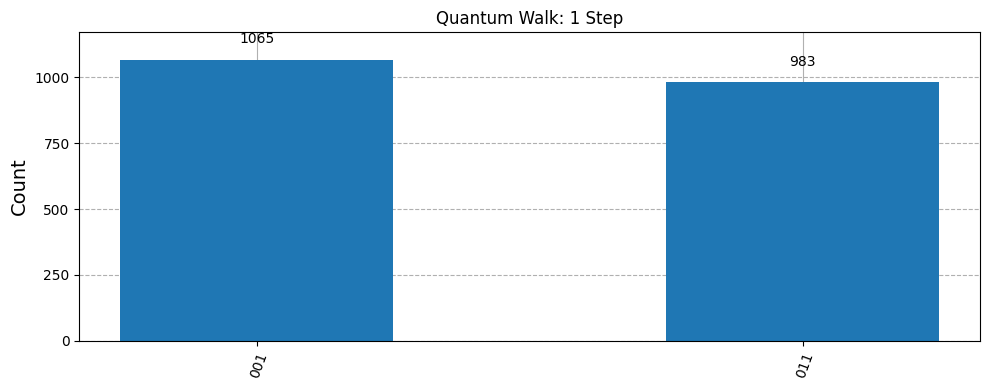

In [27]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Create registers: 1 coin qubit, 3 position qubits, 3 classical bits
qr_coin = QuantumRegister(1, name='coin')
qr_pos = QuantumRegister(3, name='pos')
cr = ClassicalRegister(3, name='readout')
qc = QuantumCircuit(qr_coin, qr_pos, cr)

# Step 1: Apply Hadamard gate to coin qubit
qc.h(qr_coin[0])

# Step 2: Controlled increment when coin = 0
qc.x(qr_coin[0])  # Flip coin to control on |0>
qc.ccx(qr_coin[0], qr_pos[0], qr_pos[1])  # carry
qc.cx(qr_coin[0], qr_pos[0])             # sum
qc.ccx(qr_coin[0], qr_pos[1], qr_pos[2]) # carry
qc.x(qr_coin[0])  # Flip coin back

# Step 3: Controlled decrement when coin = 1
qc.cx(qr_coin[0], qr_pos[0])             # sum
qc.ccx(qr_coin[0], qr_pos[1], qr_pos[2]) # borrow
qc.ccx(qr_coin[0], qr_pos[0], qr_pos[1]) # borrow

# Step 4: Measure position
qc.measure(qr_pos, cr)

# Simulate
sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=2048).result()
counts = result.get_counts()
print(counts)

# Plot result
fig = plt.figure(figsize=(10, 4))
plot_histogram(counts, ax=fig.gca(), title=f"Quantum Walk: {1} Step")
plt.grid(True)
plt.tight_layout()
plt.show()


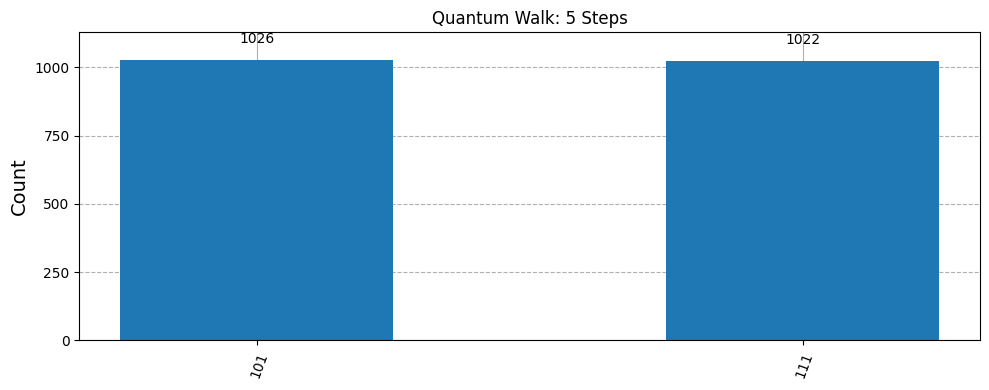

In [25]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def controlled_increment(qc, coin, pos):
    """Apply controlled increment (coin == |0⟩)"""
    qc.x(coin)  # Flip to control on |0>
    for i in range(len(pos) - 1):
        qc.ccx(coin, pos[i], pos[i + 1])
    qc.cx(coin, pos[0])
    qc.x(coin)

def controlled_decrement(qc, coin, pos):
    """Apply controlled decrement (coin == |1⟩)"""
    qc.cx(coin, pos[0])
    for i in reversed(range(1, len(pos))):
        qc.ccx(coin, pos[i - 1], pos[i])

def quantum_walk_circuit(num_steps=3, num_pos_qubits=3):
    qr_coin = QuantumRegister(1, name='coin')
    qr_pos = QuantumRegister(num_pos_qubits, name='pos')
    cr = ClassicalRegister(num_pos_qubits, name='readout')
    qc = QuantumCircuit(qr_coin, qr_pos, cr)

    # Initialize position to the center
    center = 2 ** (num_pos_qubits - 1)
    for i, bit in enumerate(format(center, f'0{num_pos_qubits}b')[::-1]):
        if bit == '1':
            qc.x(qr_pos[i])

    for _ in range(num_steps):
        qc.h(qr_coin[0])  # Hadamard coin flip
        controlled_increment(qc, qr_coin[0], qr_pos)
        controlled_decrement(qc, qr_coin[0], qr_pos)

    # Measure position
    qc.measure(qr_pos, cr)
    return qc

# --- Parameters ---
num_steps = 5
num_pos_qubits = 3

# Build and simulate
qc = quantum_walk_circuit(num_steps, num_pos_qubits)
sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=2048).result()
counts = result.get_counts()



# Plot
fig = plt.figure(figsize=(10, 4))
plot_histogram(counts, ax=fig.gca(), title=f"Quantum Walk: {num_steps} Steps")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.stats import norm, expon, entropy
import numpy as np
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt

# Quantum peg logic
def quantum_peg(qc, control, mid):

    left = mid - 1
    right = mid + 1
    print("Quantum peg on qubits:",left,mid,right)
    # print()
    if left != control and mid != control:
        qc.cswap(control, left, mid)
    qc.cx(mid, control)
    if mid != control and right != control:
        qc.cswap(control, mid, right)

# General QGB circuit builder
def generate_qgb_qiskit(n_qubits, n_levels, shots=8192):
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits )
    qc = QuantumCircuit(qr, cr)
    mid = n_qubits // 2
    theta = 5*np.pi / 6  # You can tune this
    qc.x(qr[mid])  # Ball starts in center
    # qc.h(qr[0])  # Ball starts in center
    qc.ry(theta, qr[0])  # Biased coin
    # for i in range(n_levels):
    #     print("For level=",i)
    #     control = 0
    #     if i == 0:
    #         # quantum_peg(qc, control, mid)
    #     else:
    #         qc.reset(qr[control])
    #         qc.h(qr[control])

    for j in range(n_levels):
      mid2=mid
      print("For level=",j)
      control = 0
      if j == 0:
             quantum_peg(qc, control, mid)
      else:
          qc.reset(qr[control])
          qc.ry(theta, qr[control])  # ← Bias instead of Hadamard
          mid2=mid2-j
          for i in range(j+1):
            rightmost=mid2+1
            if( mid2-1 !=0 and mid2 + 1 !=n_qubits ):
              print("mid2=",mid2)
              quantum_peg(qc, control, mid2 )
              if (i!=j):
                qc.cx(qr[rightmost], qr[control])
              mid2=mid2+2
              print("Updated mid2=",mid2)
              # quantum_peg(qc, control, mid + (j))
    qc.barrier()
    for i in range(1, n_qubits ):
        qc.measure(qr[i], cr[i])
    print(qc.draw())
    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    print (counts)
    plt.figure(figsize=(10, 5))
    # Plot raw measurement histogram before postprocessing
    plot_histogram(counts, title="Raw QGB Measurement Counts")
    plt.show()
    return counts

# Post-processing
def process_results(counts, dist_type="gaussian"):
    keys = list(counts.keys())
    values = [int(k, 2) for k in keys]
    total = sum(counts.values())
    normalized_sim = {int(k, 2): v / total for k, v in counts.items()}
    x = np.arange(min(values), max(values)+1)

    if dist_type == "gaussian":
        mu, sigma = 16, np.sqrt(5)
        ideal = norm.pdf(x, mu, sigma)
    elif dist_type == "exponential":
        ideal = expon.pdf(x, scale=4)
    else:
        ideal = np.ones_like(x) / len(x)

    ideal = ideal #/ np.sum(ideal)
    sim = np.array([normalized_sim.get(i, 0) for i in x])
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))

    plt.figure(figsize=(10, 5))
    plt.bar(x, sim, label="QGB Simulated", alpha=0.6)
    plt.plot(x, ideal, label=f"Ideal {dist_type.title()} Distribution", color="r", linestyle="--")
    plt.xlabel("Output value")
    plt.ylabel("Probability")
    plt.title(f"QGB Simulation vs. Ideal {dist_type.title()} Distribution")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return kl, tvd, normalized_sim
# Post-processing with 4-bit rescaling and block summing
def process_and_plot_blocked(counts, dist_type="gaussian"):
    shots = sum(counts.values())
    strings = []
    for bitstring, count in counts.items():
        strings.extend([bitstring] * count)

    remapped = []
    for s in strings:
        index = s[::-1].find('1')
        remapped.append(index if index != -1 else 4)  # Map to 0–4

    blocks = [sum(remapped[i:i+8]) for i in range(0, len(remapped), 8) if len(remapped[i:i+8]) == 8]
    x = sorted(set(blocks))
    hist = {i: blocks.count(i) for i in x}
    total = sum(hist.values())
    normalized_sim = {k: v / total for k, v in hist.items()}

    x_vals = np.arange(min(x), max(x) + 1)
    sim = np.array([normalized_sim.get(i, 0) for i in x_vals])

    if dist_type == "gaussian":
        mu, sigma = 16, np.sqrt(5)
        ideal = norm.pdf(x_vals, mu, sigma)
    elif dist_type == "exponential":
        ideal = expon.pdf(x_vals, scale=4)
    else:
        ideal = np.ones_like(x_vals) / len(x_vals)

    ideal = ideal #/ np.sum(ideal)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))

    plt.figure(figsize=(10, 5))
    plt.bar(x_vals, sim, label="QGB Simulated", alpha=0.6)
    plt.plot(x_vals, ideal, label=f"Ideal {dist_type.title()} Distribution", color="r", linestyle="--")
    plt.xlabel("Sum of 8 Block Values")
    plt.ylabel("Probability")
    plt.title(f"Postprocessed QGB Output vs. Ideal {dist_type.title()} Distribution")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return kl, tvd, normalized_sim

# Run for 2 layers
layers = 5
n_qubits = 2 * layers + 2
counts = generate_qgb_qiskit(n_qubits, layers)
print(counts)
# kl_gauss, tvd_gauss, _ = process_and_plot_blocked(counts, dist_type="gaussian")

# counts_exp = generate_qgb_qiskit(n_qubits, layers)
# kl_exp, tvd_exp, _ = process_and_plot_blocked(counts_exp, dist_type="exponential")


For level= 0
Quantum peg on qubits: 5 6 7
For level= 1
mid2= 5
Quantum peg on qubits: 4 5 6
Updated mid2= 7
mid2= 7
Quantum peg on qubits: 6 7 8
Updated mid2= 9
For level= 2
mid2= 4
Quantum peg on qubits: 3 4 5
Updated mid2= 6
mid2= 6
Quantum peg on qubits: 5 6 7
Updated mid2= 8
mid2= 8
Quantum peg on qubits: 7 8 9
Updated mid2= 10
For level= 3
mid2= 3
Quantum peg on qubits: 2 3 4
Updated mid2= 5
mid2= 5
Quantum peg on qubits: 4 5 6
Updated mid2= 7
mid2= 7
Quantum peg on qubits: 6 7 8
Updated mid2= 9
mid2= 9
Quantum peg on qubits: 8 9 10
Updated mid2= 11
For level= 4
mid2= 2
Quantum peg on qubits: 1 2 3
Updated mid2= 4
mid2= 4
Quantum peg on qubits: 3 4 5
Updated mid2= 6
mid2= 6
Quantum peg on qubits: 5 6 7
Updated mid2= 8
mid2= 8
Quantum peg on qubits: 7 8 9
Updated mid2= 10
mid2= 10
Quantum peg on qubits: 9 10 11
Updated mid2= 12
       ┌──────────┐   ┌───┐        ┌──────────┐   ┌───┐   ┌───┐   ┌───┐        »
 q2_0: ┤ Ry(5π/6) ├─■─┤ X ├─■──|0>─┤ Ry(5π/6) ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■──

<Figure size 1000x500 with 0 Axes>

{'000010000000': 23, '001000000000': 1, '000000100000': 322, '000000001000': 1983, '000000000010': 5863}


['00000010', '00001000', '00100000', '10000000']


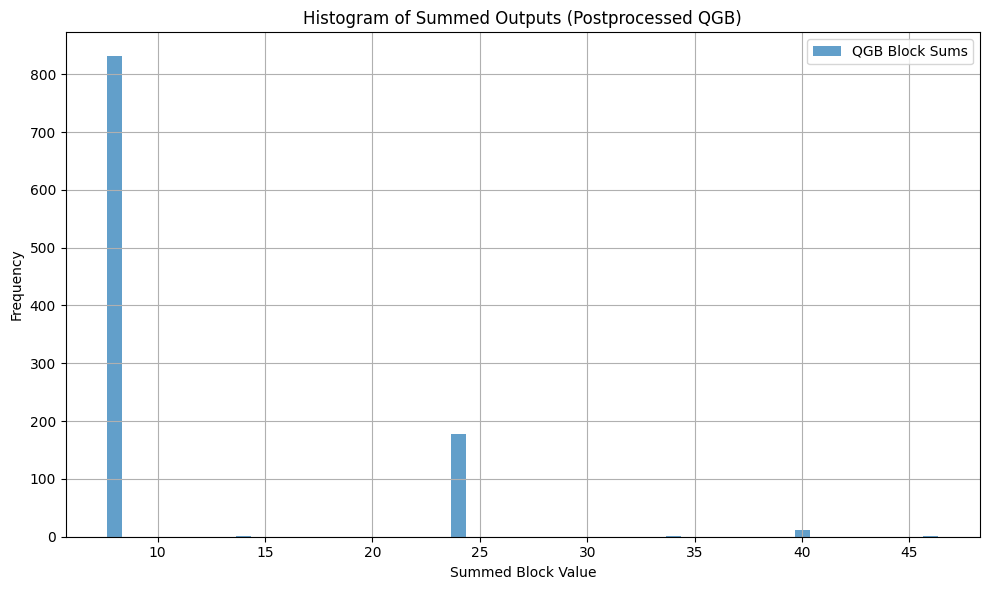

KL Divergence: 4.511388821797624
TVD: 2.99502457652329


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Generic function to map 1-hot bitstring to integer index
def one_hot_to_int(bitstring):
    # Qiskit gives bitstrings in little-endian, so reverse it
    bitstring = bitstring[::-1]
    if bitstring.count('1') != 1:
        return None  # Not a valid 1-hot bitstring
    return bitstring.index('1')

# Step 1: Expand counts into a flat sample list
def expand_onehot_counts(counts):
    samples = []
    for bitstring, freq in counts.items():
        val = one_hot_to_int(bitstring)
        if val is not None:
            samples.extend([val] * freq)
    return samples

# Step 2: Postprocessing block sum
def block_sum_postprocessing(samples, block_size=8):
    num_blocks = len(samples) // block_size
    block_sums = [
        sum(samples[i*block_size:(i+1)*block_size])
        for i in range(num_blocks)
    ]
    return block_sums

# Step 3: Plotting
def plot_histogram_and_gaussian(block_sums):
    hist = Counter(block_sums)
    sorted_keys = sorted(hist.keys())
    frequencies = [hist[k] for k in sorted_keys]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_keys, frequencies, width=0.7, alpha=0.7, label='QGB Block Sums')
    plt.xlabel("Summed Block Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Summed Outputs (Postprocessed QGB)")
    plt.grid(True)

    # Overlay Gaussian
    mean = np.mean(block_sums)
    std = np.std(block_sums)
    mean, scale = np.mean(block_sums), np.std(block_sums)
    x = np.linspace(min(sorted_keys), max(sorted_keys), 500)
    gaussian = len(block_sums) * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
    # plt.plot(x, 16.5*gaussian, color='red', linewidth=2, label='Normal Distribution')

    plt.legend()
    plt.tight_layout()
    plt.show()
    sim = np.array([hist.get(i, 0) for i in x]) / sum(sorted_keys)
    ideal = expon.pdf(x, scale=scale)
    ideal /= np.sum(ideal)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))
    return kl, tvd

# Example usage:
# counts = {'0010000000': 130, '0001000000': 246, '1000000000': 135, '0000100000': 513, ...}
samples = expand_onehot_counts(counts)
print(sorted(counts.keys()))
block_sums = block_sum_postprocessing(samples, block_size=8)
kl,tvd=plot_histogram_and_gaussian(block_sums)
# print("KL Divergence:", kl)
# print("TVD:", tvd)
